# Load the relevant modules to compute leverage scores
### The P2S2 code has been modified here to get the leverage scores

In [2]:
from dipy.io.image import load_nifti, save_nifti
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn
import time
from dipy.utils.optpkg import optional_package
from sklearn.utils.extmath import randomized_svd
import dipy.core.optimize as opt
import math

sklearn, has_sklearn, _ = optional_package('sklearn')
linear_model, _, _ = optional_package('sklearn.linear_model')

if not has_sklearn:
    w = "Scikit-Learn is required to denoise the data via Patch2Self."
    warn(w)
    

def _vol_split(train, vol_idx):
    """ Split the 3D volumes into the train and test set.

    Parameters
    ----------
    train : ndarray
        Array of all 3D patches flattened out to be 2D.

    vol_idx: int
        The volume number that needs to be held out for training.

    Returns
    --------
    cur_x : 2D-array (nvolumes*patch_size) x (nvoxels)
        Array of patches corresponding to all the volumes except for the
        held-out volume.

    y : 1D-array
        Array of patches corresponding to the volume that is used a target for
        denoising.
    """
    # Hold-out the target volume
    mask = np.zeros(train.shape[0])
    mask[vol_idx] = 1
    cur_x = train[mask == 0]
    cur_x = cur_x.reshape(((train.shape[0]-1)*train.shape[1],
                           train.shape[2]))

    # Center voxel of the selected block
    y = train[vol_idx, train.shape[1]//2, :]
    return cur_x, y

def count_sketch(matrixA, s):
    m, n = matrixA.shape
    matrixC = np.zeros([s, n])
    hashedIndices = np.random.choice(s, m, replace=True)
    # a m-by-1 {+1, -1} vector
    randSigns = np.random.choice(2, m, replace=True) * 2 - 1  
    
    # flip the signs of 50% rows of A
    matrixA = matrixA * randSigns.reshape(m, 1)  
    
    # this loop directly computes matrixC= S * matrixA
    for i in range(s):  
        idx = (hashedIndices == i)
        matrixC[i] = np.sum(matrixA[idx], 0)
    
    return matrixC[:, np.newaxis, :]


def _real_fft(matrixA):
    
    n_int = matrixA.shape[0]
    fft_mat = np.fft.fft(matrixA, n=None, axis=0) / np.sqrt(n_int)
    if n_int % 2 == 1:
        cutoff_int = int((n_int+1) / 2)
        idx_real_vec = list(range(1, cutoff_int))
        idx_imag_vec = list(range(cutoff_int, n_int))
    else:
        cutoff_int = int(n_int/2)
        idx_real_vec = list(range(1, cutoff_int))
        idx_imag_vec = list(range(cutoff_int+1, n_int))
    matrixC = fft_mat.real
    matrixC[idx_real_vec] *= np.sqrt(2)
    matrixC[idx_imag_vec] = fft_mat[idx_imag_vec].imag * np.sqrt(2)
    return matrixC[:, np.newaxis, :]

def deter_row_sample(matrixA, s):
    lev_scores = lev_exact(matrixA)
    idx_vec = np.argsort(lev_scores, axis=0)[::-1][range(s)]  # [lev_scores<0.003]
    matrixC = matrixA[idx_vec, :]
    return matrixC[:, np.newaxis, :]

def srft(matrixA, s):

    n_int = matrixA.shape[0]
    sign_vec = np.random.choice(2, n_int) * 2 - 1
    idx_vec = np.random.choice(n_int, s, replace=False)
    a_mat = sign_vec.reshape(n_int,1) * matrixA
    a_mat = _real_fft(matrixA)
    matrixC = matrixA[idx_vec] * np.sqrt(n_int / s)

    return matrixC[:, np.newaxis, :]

def lev_approx(matrixA, lev_sketch_type, lev_sketch_size=5):
    
    m, n = matrixA.shape
    s = int(n * lev_sketch_size)
    
    if lev_sketch_type == 'countsketch':
        matrixB = np.squeeze(count_sketch(matrixA, s))
        
    elif lev_sketch_type == 'srft':
        matrixB = np.squeeze(srft(matrixA, s))
        
    elif lev_sketch_type == 'uniform':
        idx_vec = np.random.choice(m, s, replace=False)
        matrixB = matrixA[idx_vec] * (m / s)
        print(matrixB.shape)
    
    elif lev_sketch_type == 'exact':
        matrixB = matrixA
    
    _, S, V = np.linalg.svd(matrixB, full_matrices=False)
    
    matrixT = V.T / S
    matrixY = np.dot(matrixA, matrixT)
    
    lev_vec = np.sum(matrixY ** 2, axis=1)
    return lev_vec

def ridge_lev_approx(matrixA, alpha):
    matrixA_alpha= np.concatenate((matrixA, np.sqrt(alpha)*np.identity(matrixA.shape[1])), axis=0)
    ridge_vec=lev_approx(matrixA_alpha)
    return ridge_vec[0:matrixA.shape[0]]

def row_sample(matrixA, s, prob_vec):
    m = matrixA.shape[0]
    prob_vec /= sum(prob_vec)
    idx_vec = np.random.choice(m, s, replace=False, p=prob_vec)
    scaling_vec = np.sqrt(s * prob_vec[idx_vec]) + 1e-10
    matrixC = matrixA[idx_vec] / scaling_vec.reshape(len(scaling_vec),1)
    return matrixC[:, np.newaxis, :]

def lev_exact(a_mat, low_rank=False):
    n_int = a_mat.shape[0]
    _ , _, v_mat = np.linalg.svd(a_mat.T, full_matrices=False)
    
    if low_rank:
        _, _, v_mat = randomized_svd(a_mat.T, 
                                     n_components=20,
                                     n_iter=5,
                                     random_state=None)
    lev_vec = np.sum(v_mat ** 2, axis=0)
    return lev_vec

def uniform_sampling(matrixA, s):
    m, n = matrixA.shape
    idx_vec = np.random.choice(m, s, replace=True)
    matrixC = matrixA[idx_vec]
    return matrixC[:, np.newaxis, :]

def sketch_data(matrixA, s, sketching_method, lev_sketch_type):
    
    if sketching_method == 'srft':
        return srft(matrixA, s)
    
    if sketching_method == 'uniform':
        return uniform_sampling(matrixA, s)
    
    if sketching_method == 'countsketch':
        return count_sketch(matrixA, s)
    
    if sketching_method == 'lev_deterministic':
        return deter_row_sample(matrixA, s)
    
    if sketching_method == 'leverage_scores':
        if lev_sketch_type == 'uniform':
            leverage_scores = lev_approx(matrixA, lev_sketch_type='uniform')
            return row_sample(matrixA, s, leverage_scores)
        
        elif lev_sketch_type == 'countsketch':
            leverage_scores = lev_approx(matrixA, lev_sketch_type='countsketch')
            return row_sample(matrixA, s, leverage_scores)
        
        elif lev_sketch_type == 'srft':
            leverage_scores = lev_approx(matrixA, lev_sketch_type='srft')
            return row_sample(matrixA, s, leverage_scores)
        
        elif lev_sketch_type == 'exact':
            leverage_scores = lev_exact(matrixA)
            return row_sample(matrixA, s, leverage_scores)

def _vol_denoise(train, sketched_train, vol_idx, 
                 model, data_shape, alpha):
    """ Denoise a single 3D volume using a train and test phase.

    Parameters
    ----------
    train : ndarray
        Array of all 3D patches flattened out to be 2D.

    vol_idx : int
        The volume number that needs to be held out for training.

    model : string, or initialized linear model object.
            This will determine the algorithm used to solve the set of linear
            equations underlying this model. If it is a string it needs to be
            one of the following: {'ols', 'ridge', 'lasso'}. Otherwise,
            it can be an object that inherits from
            `dipy.optimize.SKLearnLinearSolver` or an object with a similar
            interface from Scikit-Learn:
            `sklearn.linear_model.LinearRegression`,
            `sklearn.linear_model.Lasso` or `sklearn.linear_model.Ridge`
            and other objects that inherit from `sklearn.base.RegressorMixin`.
            Default: 'ridge'.

    data_shape : ndarray
        The 4D shape of noisy DWI data to be denoised.

    alpha : float, optional
        Regularization parameter only for ridge and lasso regression models.
        default: 1.0

    Returns
    --------
    model prediction : ndarray
        Denoised array of all 3D patches flattened out to be 2D corresponding
        to the held out volume `vol_idx`.

    """
    # To add a new model, use the following API
    # We adhere to the following options as they are used for comparisons
    if model.lower() == 'ols':
        model = linear_model.LinearRegression(copy_X=False)

    elif model.lower() == 'ridge':
        model = linear_model.Ridge(copy_X=False, alpha=alpha, solver='lsqr')

    elif model.lower() == 'lasso':
        model = linear_model.Lasso(copy_X=False, max_iter=50, alpha=alpha)

    elif (isinstance(model, opt.SKLearnLinearSolver) or
          has_sklearn and isinstance(model, sklearn.base.RegressorMixin)):
        model = model

    else:
        e_s = "The `solver` key-word argument needs to be: "
        e_s += "'ols', 'ridge', 'lasso' or a "
        e_s += "`dipy.optimize.SKLearnLinearSolver` object"
        raise ValueError(e_s)

    cur_x, y = _vol_split(train, vol_idx)
    r_cur_x, r_cur_y = _vol_split(sketched_train.T, vol_idx)
    
    model.fit(r_cur_x.T, r_cur_y.T)
    coefs = model.coef_

    return model.predict(cur_x.T).reshape(data_shape[0], data_shape[1],
                                          data_shape[2]), coefs

def _extract_3d_patches(arr, patch_radius):
    """ Extract 3D patches from 4D DWI data.

    Parameters
    ----------
    arr : ndarray
        The 4D noisy DWI data to be denoised.

    patch_radius : int or 1D array
        The radius of the local patch to be taken around each voxel (in
        voxels).

    Returns
    --------
    all_patches : ndarray
        All 3D patches flattened out to be 2D corresponding to the each 3D
        volume of the 4D DWI data.

    """
    if isinstance(patch_radius, int):
        patch_radius = np.ones(3, dtype=int) * patch_radius
    if len(patch_radius) != 3:
        raise ValueError("patch_radius should have length 3")
    else:
        patch_radius = np.asarray(patch_radius, dtype=int)
    patch_size = 2 * patch_radius + 1

    dim = arr.shape[-1]

    all_patches = []

    # loop around and find the 3D patch for each direction
    for i in range(patch_radius[0], arr.shape[0] -
                   patch_radius[0], 1):
        for j in range(patch_radius[1], arr.shape[1] -
                       patch_radius[1], 1):
            for k in range(patch_radius[2], arr.shape[2] -
                           patch_radius[2], 1):

                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1

                X = arr[ix1:ix2, jx1:jx2,
                        kx1:kx2].reshape(np.prod(patch_size), dim)
                
                # Random projection on the X
                all_patches.append(X)

    return np.array(all_patches).T


def patch2self(data, bvals, patch_radius=[0, 0, 0], model='ridge',
               b0_threshold=50, out_dtype=None, alpha=1.0, 
               verbose=False, sketching_method='srft', sketch_size=2000, 
               lev_sketch_type='uniform'):
    
    """ Patch2Self Denoiser

    Parameters
    ----------
    data : ndarray
        The 4D noisy DWI data to be denoised.

    bvals : 1D array
        Array of the bvals from the DWI acquisition

    patch_radius : int or 1D array, optional
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 0 (denoise in blocks of 1x1x1 voxels).

    model : string, or initialized linear model object.
            This will determine the algorithm used to solve the set of linear
            equations underlying this model. If it is a string it needs to be
            one of the following: {'ols', 'ridge', 'lasso'}. Otherwise,
            it can be an object that inherits from
            `dipy.optimize.SKLearnLinearSolver` or an object with a similar
            interface from Scikit-Learn:
            `sklearn.linear_model.LinearRegression`,
            `sklearn.linear_model.Lasso` or `sklearn.linear_model.Ridge`
            and other objects that inherit from `sklearn.base.RegressorMixin`.
            Default: 'ridge'.

    b0_threshold : int, optional
        Threshold for considering volumes as b0.

    out_dtype : str or dtype, optional
        The dtype for the output array. Default: output has the same dtype as
        the input.

    alpha : float, optional
        Regularization parameter only for ridge regression model.
        default: 1.0

    verbose : bool, optional
        Show progress of Patch2Self and time taken.

    Returns
    --------
    denoised array : ndarray
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values.

    References
    ----------

    [Fadnavis20] S. Fadnavis, J. Batson, E. Garyfallidis, Patch2Self:
                    Denoising Diffusion MRI with Self-supervised Learning,
                    Advances in Neural Information Processing Systems 33 (2020)
    """
    patch_radius = np.asarray(patch_radius, dtype=np.int)

    if not data.ndim == 4:
        raise ValueError("Patch2Self can only denoise on 4D arrays.",
                         data.shape)

    if data.shape[3] < 10:
        warn("The intput data has less than 10 3D volumes. Patch2Self may not",
             "give denoising performance.")

    if out_dtype is None:
        out_dtype = data.dtype

    # We retain float64 precision, iff the input is in this precision:
    if data.dtype == np.float64:
        calc_dtype = np.float64

    # Otherwise, we'll calculate things in float32 (saving memory)
    else:
        calc_dtype = np.float32

    # Segregates volumes by b0 threshold
    b0_idx = np.argwhere(bvals <= b0_threshold)
    dwi_idx = np.argwhere(bvals > b0_threshold)

    data_b0s = np.squeeze(np.take(data, b0_idx, axis=3))
    data_dwi = np.squeeze(np.take(data, dwi_idx, axis=3))

    # create empty arrays
    denoised_b0s = np.empty((data_b0s.shape), dtype=calc_dtype)
    denoised_dwi = np.empty((data_dwi.shape), dtype=calc_dtype)

    denoised_arr = np.empty((data.shape), dtype=calc_dtype)

    if verbose is True:
        t1 = time.time()

    # Separate denoising for DWI volumes
    train_dwi = _extract_3d_patches(np.pad(data_dwi, ((patch_radius[0],
                                                       patch_radius[0]),
                                                      (patch_radius[1],
                                                       patch_radius[1]),
                                                      (patch_radius[2],
                                                       patch_radius[2]),
                                                      (0, 0)), mode='constant'),
                                    patch_radius=patch_radius)
    
    levs = lev_exact(np.squeeze(train_dwi).T)
    sketched_train_dwi = sketch_data(np.squeeze(train_dwi).T, 
                                     sketching_method=sketching_method, 
                                     s=sketch_size, lev_sketch_type=lev_sketch_type)
    
    print(sketched_train_dwi.shape)

    # Insert the separately denoised arrays into the respective empty arrays
    coef_list = []
    for vol_idx in range(60, 61):
        denoised_dwi[..., vol_idx] = _vol_denoise(train_dwi,
                                                  sketched_train_dwi,
                                                  vol_idx, model,
                                                  data_dwi.shape,
                                                  alpha=alpha)[0]
        coefs = _vol_denoise(train_dwi,
                             sketched_train_dwi,
                             vol_idx, model,
                             data_dwi.shape,
                             alpha=alpha)[1]
        coef_list.append(coefs)

        if verbose is True:
            print("Denoised DWI Volume: ", vol_idx)

    if verbose is True:
        t2 = time.time()
        print('Total time taken for Patch2Self: ', t2-t1, " seconds")

    if data_b0s.ndim == 3:
        denoised_arr[:, :, :, b0_idx[0][0]] = denoised_b0s
    else:
        for i, idx in enumerate(b0_idx):
            denoised_arr[:, :, :, idx[0]] = np.squeeze(denoised_b0s[..., i])

    for i, idx in enumerate(dwi_idx):
        denoised_arr[:, :, :, idx[0]] = np.squeeze(denoised_dwi[..., i])

    # clip out the negative values from the denoised output
    denoised_arr.clip(min=0, out=denoised_arr)

    return np.array(denoised_arr, dtype=out_dtype), coef_list, levs

### Load the dataset of which you want to plot the leverage scores

In [3]:
data, affine = load_nifti('dwi_corr.nii.gz')
bval = np.loadtxt('corr.bval')

In [4]:
_, _, lev_sc = patch2self(data, bval, verbose=False, model='ols', 
                          patch_radius=[0, 0, 0],
                          b0_threshold=50, sketch_size=100, 
                          sketching_method='lev_deterministic')

(100, 1, 64)


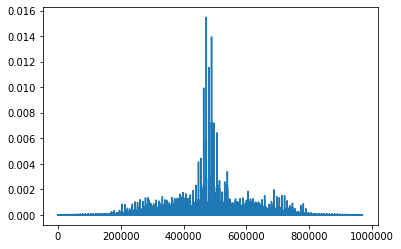

In [6]:
%matplotlib inline

plt.plot(np.arange(0, lev_sc.shape[0], 1), lev_sc)